In [1]:
import torch
import RETFound_MAE.models_vit
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.preprocessing import label_binarize
from functools import partial
from pathlib import Path
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from RETFound_MAE.util.pos_embed import interpolate_pos_embed
from timm.models.layers import trunc_normal_
from torch.nn import Linear, ReLU, CrossEntropyLoss
import timm

In [2]:
class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)
        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)
            del self.norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome

    def forward_head(self, x, pre_logits: bool = False):
        if self.global_pool:
            x = self.fc_norm(x)
        if pre_logits:
            return x
        x = self.head(x)
        return x

def vit_large_patch16(global_pool=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), global_pool=global_pool, **kwargs)
    return model

model_R = vit_large_patch16(num_classes=3, drop_path_rate=0.2, global_pool=True)

In [3]:
checkpoint = torch.load('RETFound_cfp_weights.pth', map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model_R.state_dict()

for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

interpolate_pos_embed(model_R, checkpoint_model)

msg = model_R.load_state_dict(checkpoint_model, strict=False)
assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}

trunc_normal_(model_R.head.weight, std=2e-5)

data_dir = Path('PAPILA')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir / 'train', transform=transform)
val_dataset = datasets.ImageFolder(root=data_dir / 'val', transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir / 'test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_R.to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model_R.parameters(), lr=1e-4)

num_epochs = 25
best_val_acc = 0.0

In [5]:
for epoch in range(num_epochs):
    model_R.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model_R(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    model_R.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model_R(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_R.state_dict(), 'best_model.pth')

model_R.load_state_dict(torch.load('best_model.pth'))
model_R.eval()

test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model_R(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_acc = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1/25, Train Loss: 0.9155, Train Acc: 0.6624, Val Loss: 0.8379, Val Acc: 0.6835
Epoch 2/25, Train Loss: 0.8558, Train Acc: 0.6817, Val Loss: 0.8292, Val Acc: 0.6835
Epoch 3/25, Train Loss: 0.8301, Train Acc: 0.6817, Val Loss: 0.8204, Val Acc: 0.6835
Epoch 4/25, Train Loss: 0.8257, Train Acc: 0.6817, Val Loss: 0.8484, Val Acc: 0.6835
Epoch 5/25, Train Loss: 0.7366, Train Acc: 0.7074, Val Loss: 0.7688, Val Acc: 0.6709
Epoch 6/25, Train Loss: 0.6329, Train Acc: 0.7717, Val Loss: 0.7151, Val Acc: 0.7468
Epoch 7/25, Train Loss: 0.6271, Train Acc: 0.7588, Val Loss: 0.7280, Val Acc: 0.7342
Epoch 8/25, Train Loss: 0.6338, Train Acc: 0.7492, Val Loss: 0.6719, Val Acc: 0.7468
Epoch 9/25, Train Loss: 0.4419, Train Acc: 0.8167, Val Loss: 0.7831, Val Acc: 0.7595
Epoch 10/25, Train Loss: 0.4183, Train Acc: 0.8328, Val Loss: 0.8043, Val Acc: 0.7468
Epoch 11/25, Train Loss: 0.3801, Train Acc: 0.8585, Val Loss: 0.8982, Val Acc: 0.6962
Epoch 12/25, Train Loss: 0.4062, Train Acc: 0.8489, Val Loss: 0

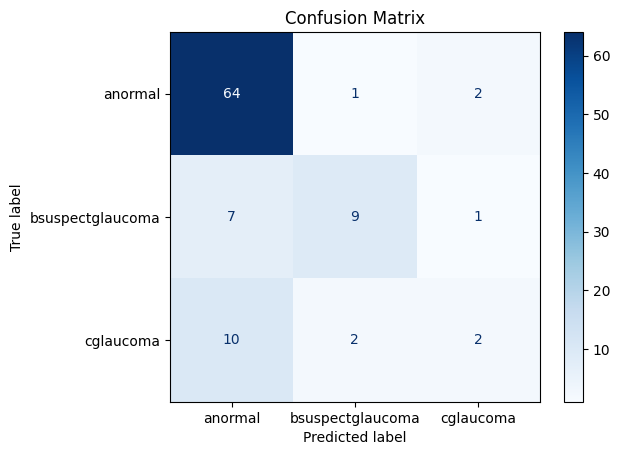

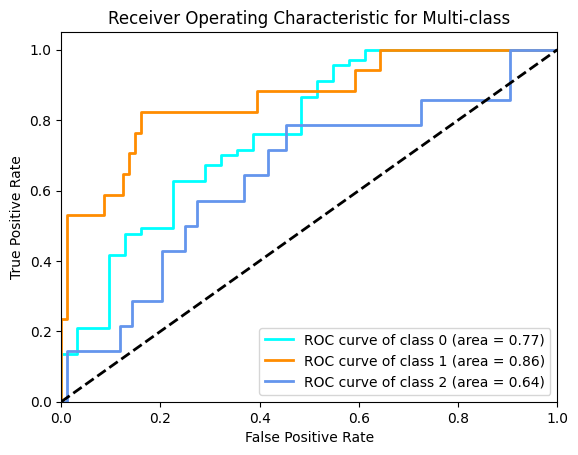

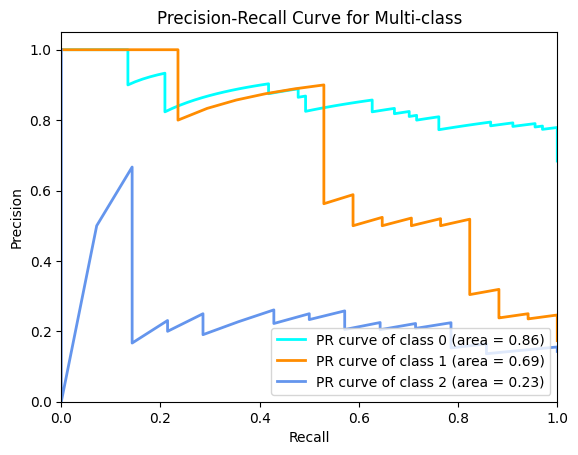

In [7]:
cm = confusion_matrix(all_labels, np.argmax(all_preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

all_preds = np.array(all_preds)

all_labels = np.array(all_labels)
n_classes = len(test_dataset.classes)
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'darkorange', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right")
plt.show()

precision = dict()
recall = dict()
pr_auc = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_bin[:, i], all_preds[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='PR curve of class {0} (area = {1:0.2f})'
             ''.format(i, pr_auc[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()